In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [2]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual2.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [4]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -100 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [7]:
#totals = [0.0]
#θ = zeros(length(grid),6);
#e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [8]:

N = 500
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.3
γ = 0.98
ϵ = 0.3
x = [20, 60, 90, 1, 1];
λ = 0.98
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0
epochsize = 500

500

In [14]:
## test loop

epochs = 100000

collisions = 0
losses = 0
total = 0
#total = 0
#rando = 0
k = 15
last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
#b = ParticleCollection([x[1:4] for i in 1:N]);     
#ξ = sparse(weighted_grid_2(b)/N)
uu = next_action([1, 2, 3, 4, 5, 6], 1, rng)
u = uu[1]

for i in 1:(epochsize*epochs)
    counter += 1
    
    # choose next action
    #uu = next_action([1, 2, 3, 4, 5, 6], 1, rng)
    u = rand(rng, 1:6)
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    #y = h(xp, rng)
    #b = update(pfilter, b, actions_[u], y)
    #rew = r(Tuple(xp))
       
    #ξ = sparse(weighted_grid_2(b)/N)
     
    #total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    #cur = transpose(θ[:,a_star])*ξ
    
    #δ = rew + γ * cur - last
    
    #θ += α * δ * e
    #if uu[2] == 0
    #e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
    
    
    if (counter % epochsize == 0) || (xp[1] <= 10)
        total += 1
        if xp[1] <= 10 collisions += 1 end
        if xp[1] > 150 losses += 1 end
        if counter & (epochsize*1000) == 0 
            println("--------- ROUND: ", total, " COLLISIONS: ", round(100*collisions/total, sigdigits=4), 
            "% LOSSES: ", round(100*losses/total, sigdigits=4), "% -----------")
        end
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        #b = ParticleCollection([xp[1:4] for i in 1:N]);
        #ξ = sparse(weighted_grid_2(b)/N)       
    end
   
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- ROUND: 240 COLLISIONS: 16.25% LOSSES: 48.75% -----------
--------- ROUND: 241 COLLISIONS: 16.18% LOSSES: 48.96% -----------
--------- ROUND: 246 COLLISIONS: 16.26% LOSSES: 48.78% -----------
--------- ROUND: 247 COLLISIONS: 16.19% LOSSES: 48.99% -----------
--------- ROUND: 248 COLLISIONS: 16.13% LOSSES: 48.79% -----------
--------- ROUND: 251 COLLISIONS: 16.33% LOSSES: 48.61% -----------
--------- ROUND: 293 COLLISIONS: 17.06% LOSSES: 47.1% -----------
--------- ROUND: 1499 COLLISIONS: 16.81% LOSSES: 46.9% -----------
--------- ROUND: 1501 COLLISIONS: 16.86% LOSSES: 46.84% -----------
--------- ROUND: 1535 COLLISIONS: 16.74% LOSSES: 46.84% -----------
--------- ROUND: 1536 COLLISIONS: 16.73% LOSSES: 46.88% -----------
--------- ROUND: 1537 COLLISIONS: 16.72% LOSSES: 46.91% -----------
--------- ROUND: 1541 COLLISIONS: 16.74% LOSSES: 46.85% -----------
--------- ROUND: 1542 COLLISIONS: 16.73% LOSSES: 46.82% -----------
--------- ROUND: 1543 COLLISIONS: 16.72% LOSSES: 46.79% -

--------- ROUND: 16395 COLLISIONS: 15.68% LOSSES: 47.36% -----------
--------- ROUND: 16396 COLLISIONS: 15.68% LOSSES: 47.36% -----------
--------- ROUND: 16397 COLLISIONS: 15.68% LOSSES: 47.36% -----------
--------- ROUND: 16431 COLLISIONS: 15.67% LOSSES: 47.39% -----------
--------- ROUND: 16432 COLLISIONS: 15.67% LOSSES: 47.39% -----------
--------- ROUND: 16433 COLLISIONS: 15.67% LOSSES: 47.39% -----------
--------- ROUND: 16437 COLLISIONS: 15.67% LOSSES: 47.38% -----------
--------- ROUND: 16438 COLLISIONS: 15.66% LOSSES: 47.38% -----------
--------- ROUND: 16442 COLLISIONS: 15.67% LOSSES: 47.39% -----------
--------- ROUND: 16443 COLLISIONS: 15.67% LOSSES: 47.39% -----------
--------- ROUND: 16444 COLLISIONS: 15.67% LOSSES: 47.4% -----------
--------- ROUND: 16446 COLLISIONS: 15.67% LOSSES: 47.39% -----------
--------- ROUND: 17628 COLLISIONS: 15.62% LOSSES: 47.4% -----------
--------- ROUND: 17629 COLLISIONS: 15.62% LOSSES: 47.4% -----------
--------- ROUND: 17630 COLLISIONS: 15

--------- ROUND: 29935 COLLISIONS: 15.28% LOSSES: 47.44% -----------
--------- ROUND: 29942 COLLISIONS: 15.27% LOSSES: 47.44% -----------
--------- ROUND: 29943 COLLISIONS: 15.27% LOSSES: 47.43% -----------
--------- ROUND: 29944 COLLISIONS: 15.27% LOSSES: 47.44% -----------
--------- ROUND: 29981 COLLISIONS: 15.28% LOSSES: 47.43% -----------
--------- ROUND: 31175 COLLISIONS: 15.3% LOSSES: 47.44% -----------
--------- ROUND: 31176 COLLISIONS: 15.3% LOSSES: 47.43% -----------
--------- ROUND: 31181 COLLISIONS: 15.3% LOSSES: 47.43% -----------
--------- ROUND: 31183 COLLISIONS: 15.31% LOSSES: 47.43% -----------
--------- ROUND: 31184 COLLISIONS: 15.31% LOSSES: 47.43% -----------
--------- ROUND: 31185 COLLISIONS: 15.31% LOSSES: 47.43% -----------
--------- ROUND: 31213 COLLISIONS: 15.3% LOSSES: 47.44% -----------
--------- ROUND: 31217 COLLISIONS: 15.3% LOSSES: 47.44% -----------
--------- ROUND: 31218 COLLISIONS: 15.3% LOSSES: 47.44% -----------
--------- ROUND: 31219 COLLISIONS: 15.3%

--------- ROUND: 44844 COLLISIONS: 15.41% LOSSES: 47.58% -----------
--------- ROUND: 44851 COLLISIONS: 15.41% LOSSES: 47.58% -----------
--------- ROUND: 44886 COLLISIONS: 15.41% LOSSES: 47.58% -----------
--------- ROUND: 44887 COLLISIONS: 15.41% LOSSES: 47.58% -----------
--------- ROUND: 46088 COLLISIONS: 15.42% LOSSES: 47.59% -----------
--------- ROUND: 46091 COLLISIONS: 15.42% LOSSES: 47.59% -----------
--------- ROUND: 46092 COLLISIONS: 15.41% LOSSES: 47.59% -----------
--------- ROUND: 46093 COLLISIONS: 15.41% LOSSES: 47.59% -----------
--------- ROUND: 46097 COLLISIONS: 15.41% LOSSES: 47.59% -----------
--------- ROUND: 46098 COLLISIONS: 15.41% LOSSES: 47.59% -----------
--------- ROUND: 46131 COLLISIONS: 15.42% LOSSES: 47.58% -----------
--------- ROUND: 46132 COLLISIONS: 15.42% LOSSES: 47.59% -----------
--------- ROUND: 46133 COLLISIONS: 15.42% LOSSES: 47.59% -----------
--------- ROUND: 46137 COLLISIONS: 15.42% LOSSES: 47.59% -----------
--------- ROUND: 46138 COLLISIONS:

--------- ROUND: 60942 COLLISIONS: 15.39% LOSSES: 47.53% -----------
--------- ROUND: 60943 COLLISIONS: 15.39% LOSSES: 47.53% -----------
--------- ROUND: 60947 COLLISIONS: 15.39% LOSSES: 47.53% -----------
--------- ROUND: 60948 COLLISIONS: 15.39% LOSSES: 47.53% -----------
--------- ROUND: 60949 COLLISIONS: 15.38% LOSSES: 47.53% -----------
--------- ROUND: 60952 COLLISIONS: 15.38% LOSSES: 47.53% -----------
--------- ROUND: 60954 COLLISIONS: 15.39% LOSSES: 47.53% -----------
--------- ROUND: 60956 COLLISIONS: 15.39% LOSSES: 47.53% -----------
--------- ROUND: 60981 COLLISIONS: 15.38% LOSSES: 47.53% -----------
--------- ROUND: 60982 COLLISIONS: 15.38% LOSSES: 47.53% -----------
--------- ROUND: 60983 COLLISIONS: 15.38% LOSSES: 47.53% -----------
--------- ROUND: 60987 COLLISIONS: 15.38% LOSSES: 47.53% -----------
--------- ROUND: 60988 COLLISIONS: 15.38% LOSSES: 47.53% -----------
--------- ROUND: 60989 COLLISIONS: 15.38% LOSSES: 47.53% -----------
--------- ROUND: 62195 COLLISIONS:

--------- ROUND: 75907 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 75908 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 75913 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 77147 COLLISIONS: 15.45% LOSSES: 47.59% -----------
--------- ROUND: 77148 COLLISIONS: 15.45% LOSSES: 47.59% -----------
--------- ROUND: 77151 COLLISIONS: 15.45% LOSSES: 47.59% -----------
--------- ROUND: 77161 COLLISIONS: 15.46% LOSSES: 47.59% -----------
--------- ROUND: 78338 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 78339 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 78342 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 78343 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 78344 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 78349 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 78350 COLLISIONS: 15.44% LOSSES: 47.59% -----------
--------- ROUND: 78353 COLLISIONS:

--------- ROUND: 91984 COLLISIONS: 15.41% LOSSES: 47.5% -----------
--------- ROUND: 91985 COLLISIONS: 15.41% LOSSES: 47.5% -----------
--------- ROUND: 91986 COLLISIONS: 15.41% LOSSES: 47.5% -----------
--------- ROUND: 91987 COLLISIONS: 15.41% LOSSES: 47.5% -----------
--------- ROUND: 93180 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93181 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93187 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93188 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93189 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93192 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93193 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93195 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93217 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93222 COLLISIONS: 15.41% LOSSES: 47.53% -----------
--------- ROUND: 93224 COLLISIONS: 15.

--------- ROUND: 108107 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108108 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108109 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108112 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108113 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108114 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108118 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108119 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108142 COLLISIONS: 15.45% LOSSES: 47.48% -----------
--------- ROUND: 108151 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108152 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 108155 COLLISIONS: 15.45% LOSSES: 47.47% -----------
--------- ROUND: 109382 COLLISIONS: 15.45% LOSSES: 47.46% -----------
--------- ROUND: 109384 COLLISIONS: 15.45% LOSSES: 47.46% -----------
--------- ROUND: 109

In [54]:
epochsize

2150

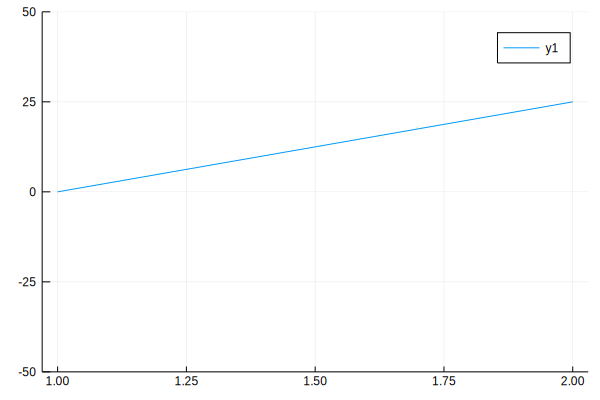

In [53]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (-50,50))

In [10]:
θ = convert(Matrix, CSV.read("0.473_final.csv"))


30420×6 Array{Float64,2}:
  -4.05719   0.0         -12.7585    0.0           -5.40401   0.0        
 -14.1363    0.0         -13.7421    0.0           -8.10245   0.0        
 -10.3976    0.0         -10.766     0.0341359    -10.7977    0.0        
  -2.55388   0.0         -18.6888    0.0183138     -9.52957   0.0        
  -1.0819    0.0157158    -0.916452  0.00300404    -0.331465  0.0        
   0.855674  0.00673533    5.65503   0.0            0.654088  0.0        
   1.16456   0.0          11.4057    0.00685856     0.607544  0.0        
   1.58071   0.0247135     3.96063   0.000762062    0.405348  0.000318762
   4.4065    0.0255353     0.472534  0.0            0.411339  0.0040335  
   5.23843   0.00871109    0.426326  0.0            0.405973  0.000776428
   5.00093   0.018768      0.61746   0.0            0.590034  0.0        
   4.63067   0.0385562     0.547618  0.0            0.593071  0.0        
   6.30795   0.00124996    0.443488  0.0            0.594687  0.0        
   ⋮        

In [17]:
#θ = convert(Matrix, thetaframe)

In [57]:
thetaframe = DataFrame(θ)
CSV.write("0.473_final.csv", thetaframe)

"0.473_final.csv"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5